**4. CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P**

Explore phase transitions for free energy by changing temperature and obtaining minimizing P.
-	Free energy vs temp for at least two probability strategies (scipy minimization and counting occurrences?)
-	If we may have bifurcation, one need to do several copies/simulations for the same network/brain
-	Compute this in a random graph, a scale free graph (similar size as brain)
-	Compute in a fmri based in mut info
-	Compute in structural connector (see dropbox Fernando sent - see Jupiter notes).

**Obtain the minimum free energy for a given clique complex**

In [ ]:
# Import libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

: 

In [ ]:
clique_complex_list = [[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({2, 3})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({1, 4, 6})]]

In [54]:
# Define shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Internal energy function
def energy_function(x, Q):
    return x.T @ Q @ x

# Free energy function
def free_energy_function(x, Q, t):
    entropy_term = - np.sum(x * np.log2(np.maximum(x, 1e-10)))  # Avoid log(0), changed to np.log2 to improve speed.
    return t*(x.T @ Q @ x) - (1-t) * entropy_term

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

# Find the minimum free energy for a given clique complex
def complete_f_generator_scipy(clique_complex, t):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

def complete_f_generator(clique_complex):
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_list = []
    temperature_list = np.arange(0, 1, 0.01)

    for temperature in temperature_list:
        f = complete_f_generator_scipy(clique_complex_list[0], temperature)[0]
        f_list.append(f)

    return f_list, temperature_list, min_energy_value, max_entropy_value

c:\Users\cyril\anaconda3\envs\TDA_danillo\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


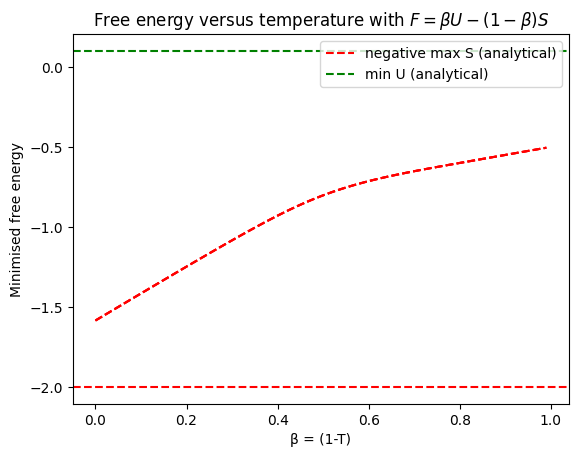

In [62]:
for i in range(0, len(clique_complex_list)):
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex_list[i])
    plt.plot(temperature_list, f_list, 'r--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [70]:
import networkx as nx
import itertools

# Define a function to find all maximal cliques in a graph
def find_maximal_cliques(graph):
    return list(nx.find_cliques(graph))

# Define a function to generate the clique complex from the list of cliques
def generate_clique_complex(cliques):
    clique_complex = []
    for clique in cliques:
        # Sort the nodes in the clique to maintain the order
        clique.sort()
        # Generate all possible subsets of nodes (simplices)
        for i in range(1, len(clique) + 1):
            simplices = [frozenset(sorted(subset)) for subset in itertools.combinations(clique, i)]
            clique_complex.extend(sorted(simplices))
    return clique_complex

# Generate a random graph
num_nodes = 10
probability = 0.3
dataset_size = 10
clique_complex_list = []

# Generate random clique_complex_list
for i in range(0, dataset_size):
    random_graph = nx.erdos_renyi_graph(num_nodes, probability)
    maximal_cliques = find_maximal_cliques(random_graph)
    clique_complex = generate_clique_complex(maximal_cliques)
    clique_complex_list.append(clique_complex)

In [71]:
for i in range(0, len(clique_complex_list)):
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex_list[i])
    plt.plot(temperature_list, f_list, 'r--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

LinAlgError: Singular matrix